# Exemplo: Modelo de Linguagem (RNN)


In [54]:
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)
file = unidecode.unidecode(open('./data/GrandeSertoVeredasGuimaresRosa.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 1088123


Divide o conjunto de dados em pedaços menores para uso durante o treino

In [56]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

So Candelario tivesse afirmado coisas de sincera importancia.
Ze Bebelo abriu muito a boca, tirando um ronco, como que de
proposito. Alguns, mais riram dele. Em menos Joca Ramiro
esperou um instante:
-


# Define o modelo

Este modelo vai receber como entrada o caracter para o passo de tempo atual e produzir como saída o próximo caracter.
3 camadas:
 - 1 camada linear converte a entrada em uma representação vetorial
 - 1 camada GRU (que pode conter multiplas camadas) implementa a parte recorrente da rede
 - 1 camada linear que decodifica a saída da GRU em uma distribuição de probabilidades para o próximo caracter.


In [57]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input)
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size)

# Inputs and Targets

Cada pedaço do texto vai ser transformado em um tensor (LongTEnsor) contendo a sequencia
de indices do caracter no dicionário `all_characters`


In [58]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

print(char_tensor('abcDEF'))

tensor([ 10,  11,  12,  39,  40,  41])


Cria um part de tensores (input e target) para treino.

O tensor de entrada vai conter a sequencia de caracteres vista até o momento e o
tensor de saída vai conter a sequencia que ocorre a partir deste ponto.


In [59]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# Treinamento

In [10]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [60]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / chunk_len

Define os parâmetros de treino e o loop de treino

In [82]:
n_epochs = 1000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
       
    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

/home/juliano/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


 14s (100 10%) 2.2538]
 26s (200 20%) 2.0479]
 30s (300 30%) 2.0923]
 7s (400 40%) 2.1914]
 34s (500 50%) 1.8946]
 0s (600 60%) 2.0419]
 15s (700 70%) 1.9353]
 39s (800 80%) 1.9489]
 11s (900 90%) 1.9376]
 10s (1000 100%) 1.9656]


## Erro de treino


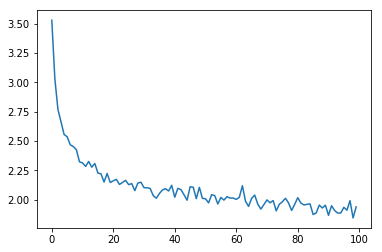

In [83]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Avaliação (sampling)

Gera novas sequencias a partir de uma sequecia inicial (priming) 

In [46]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    
    with torch.no_grad():
        hidden = decoder.init_hidden()
        prime_input = char_tensor(prime_str)
        predicted = prime_str

        # Use priming string to "build up" hidden state
        for p in range(len(prime_str) - 1):
            _, hidden = decoder(prime_input[p], hidden)
        inp = prime_input[-1]

        for p in range(predict_len):
            output, hidden = decoder(inp, hidden)

            # Sample from the network as a multinomial distribution
            output_dist = output.data.view(-1).div(temperature).exp()
            top_i = torch.multinomial(output_dist, 1)[0]

            # Add predicted character to string and use as next input
            predicted_char = all_characters[top_i]
            predicted += predicted_char
            inp = char_tensor(predicted_char)

        return predicted

In [86]:
print(evaluate('Diadorim disse', 200, temperature=0.8))

Diadorim disse que teram de boa muito do mim, se pbiao e todo piga era mais boz cabeli, disse. E erao dena, converno da por garita. Eu um ele
encenco e eno nomendo
para o
credo de carecente de mater, menonde do prr


In [65]:
print(evaluate('Th', 200, temperature=1.4))

Them.,
ai idelhei a: jissente, pasticevalenlas por pe?`;,
vinham. FazE, segos. O, sigito de esgrdre, Palse peleto-car, a, apaste
canemaito, guardoa palaspatra, podos. Depoi e eousgou Ista era
inossoapia


**Next**: [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb)